In [4]:
import sys, joblib
sys.path.append('../../..')
from grid import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
#r = joblib.load('output-taskgrammar-iter2.bin')
r = joblib.load('output-taskpeople_gibbs-iter2.bin')
result = r['result']
train = r['train']

In [ ]:
train = list(tasks_from_grammar_boards())
test = train

g0 = Grammar.uniform(
    primitives,
    # when doing grid_cont instead, we only consider $0
    # but when we only have type=tgrid_cont, then we get a nicer library for tree_tasks()
    continuationType=arrow(tgrid_cont,tgrid_cont))
arguments = commandlineArguments(
    #iterations=1,
    #enumerationTimeout=1,
    #maximumFrontier=10,
    enumerationTimeout=30,
    solver='ocaml',
    compressor="ocaml",
    activation='tanh',
    iterations=3, recognitionTimeout=3600,
    # TODO what does this arity do? seems to relate to grammar?
    a=3,
    maximumFrontier=10, topK=2, pseudoCounts=30.0,
    helmholtzRatio=0.5, structurePenalty=1.,
    CPUs=1,
)

generator = ecIterator(g0, train, testingTasks=test, **arguments)
for result in generator:
    break


# Now rendering tasks.

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline

def env_rect(grid, facecolor="none", edgecolor="k", linewidth=0.5):
    return [
        (
            s,
            plt.Rectangle((s[0]-0.5, s[1]-0.5), 1, 1, linewidth=linewidth, facecolor=facecolor, edgecolor=edgecolor),
        )
        for s in np.ndindex(grid.shape)
    ]

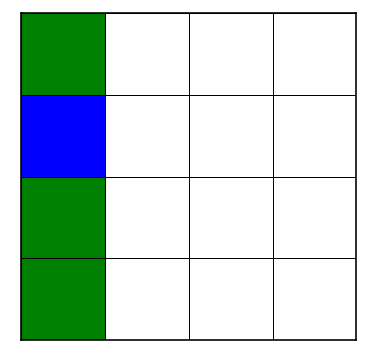

In [115]:
def showtask(start, end, history=None, *, size=3, ax=None):
    w, h = start.shape
    asp = w/h
    if ax is None:
        _, ax = plt.subplots(figsize=(size*asp, size))
    ax.set(
        xticks=[],
        yticks=[],
        xlim=[-1/2, w-1/2],
        ylim=[-1/2, h-1/2],
    )
    for xy, r in env_rect(start):
        if start[xy]:
            r.set_facecolor('blue')
        elif end[xy]:
            r.set_facecolor('green')
        ax.add_artist(r)
    if history:
        for prev, curr in zip(history[:-1], history[1:]):
            ax.plot(
                [prev['location'][0], curr['location'][0]],
                [prev['location'][1], curr['location'][1]],
                c='k')
task = next(tasks_from_grammar_boards())
_g0 = Grammar.uniform(primitives, continuationType=arrow(tgrid_cont,tgrid_cont))
s = executeGrid(_g0.sample(_g0.continuationType), GridState(task.start, task.location, history=[]))
showtask(task.start, task.goal, s.history)

# showing all solutions

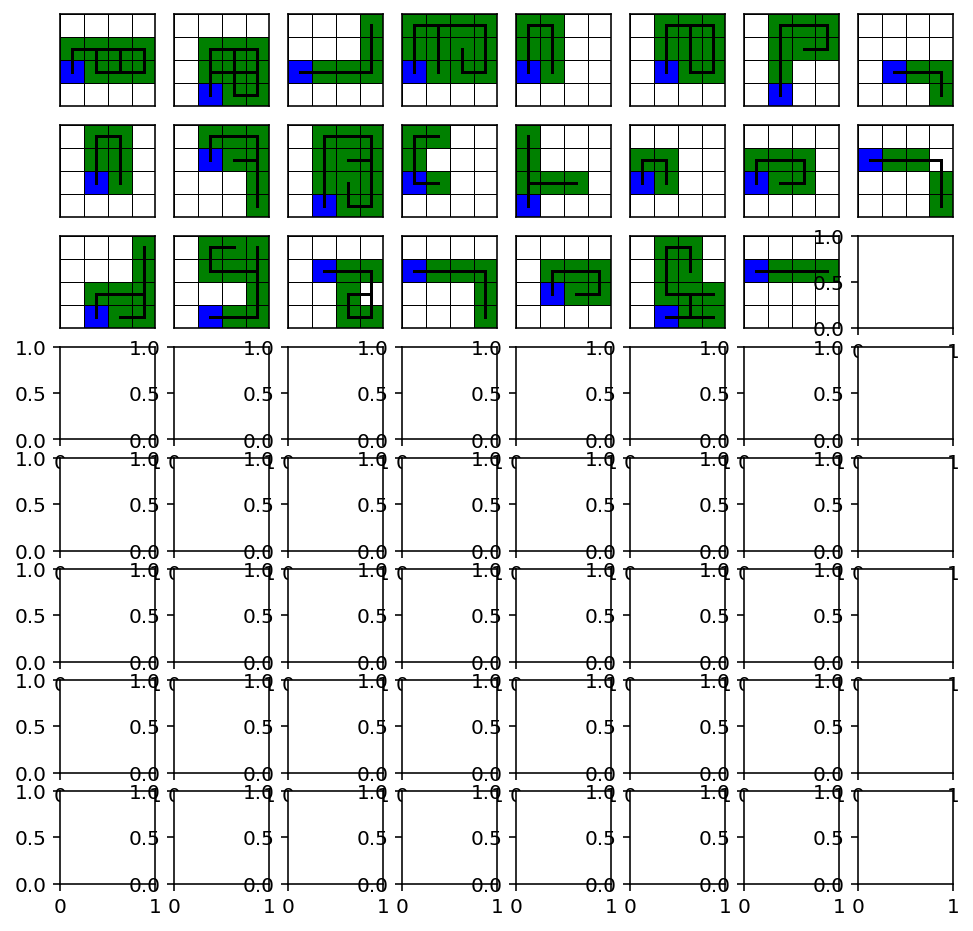

In [124]:
total = sum(1 for v in result.frontiersOverTime.values() if len(v[-1].entries))
f, axes = plt.subplots(8, 8, figsize=(8, 8))
axes = axes.flatten().tolist()

for task in train:
    es = result.frontiersOverTime[task][-1].entries
    if not es:
        continue
    fe = max(es, key=lambda e: e.logPrior) # get the best
    s = executeGrid(fe.program, GridState(task.start, task.location, history=[]))
    assert np.all(s.grid == task.goal)
    showtask(task.start, task.goal, s.history, ax=axes.pop(0))
    if not axes:
        break

# dreams

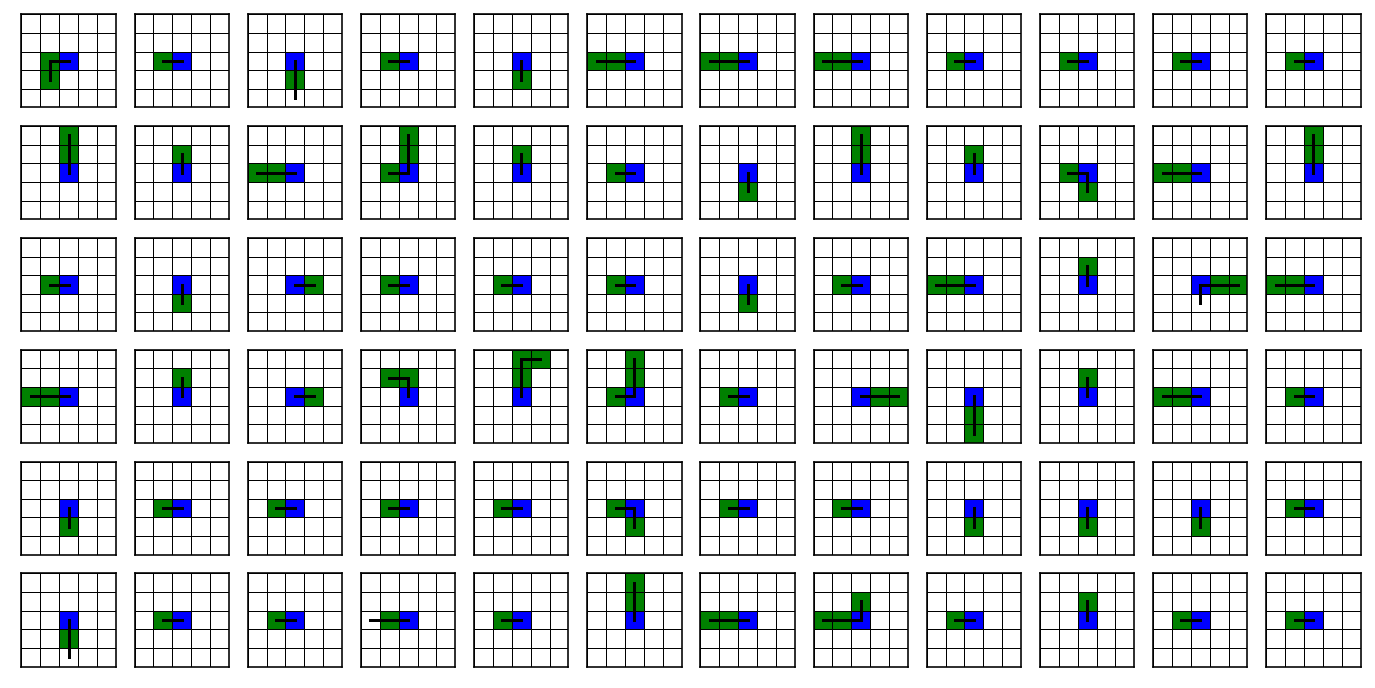

In [117]:
def dream_grammar(g):
    f, axes = plt.subplots(6, 12, figsize=(12, 6))
    axes = axes.flatten().tolist()

    #trivial = dreamcoder.program.Abstraction(dreamcoder.program.Index(0))
    programs = []

    for ax in axes:
        start, location = np.array([[0]*5]*5), (2, 2)
        start[location] = 1
        for _ in range(20):
            p = g.sample(g.continuationType)
            '''
            if p != trivial:
                break
            '''
            s = executeGrid(p, GridState(start, location, history=[]))
            if not np.all(start==s.grid):
                break
        showtask(start, s.grid, s.history, ax=ax)
        programs.append(p)

dream_grammar(result.grammars[0])

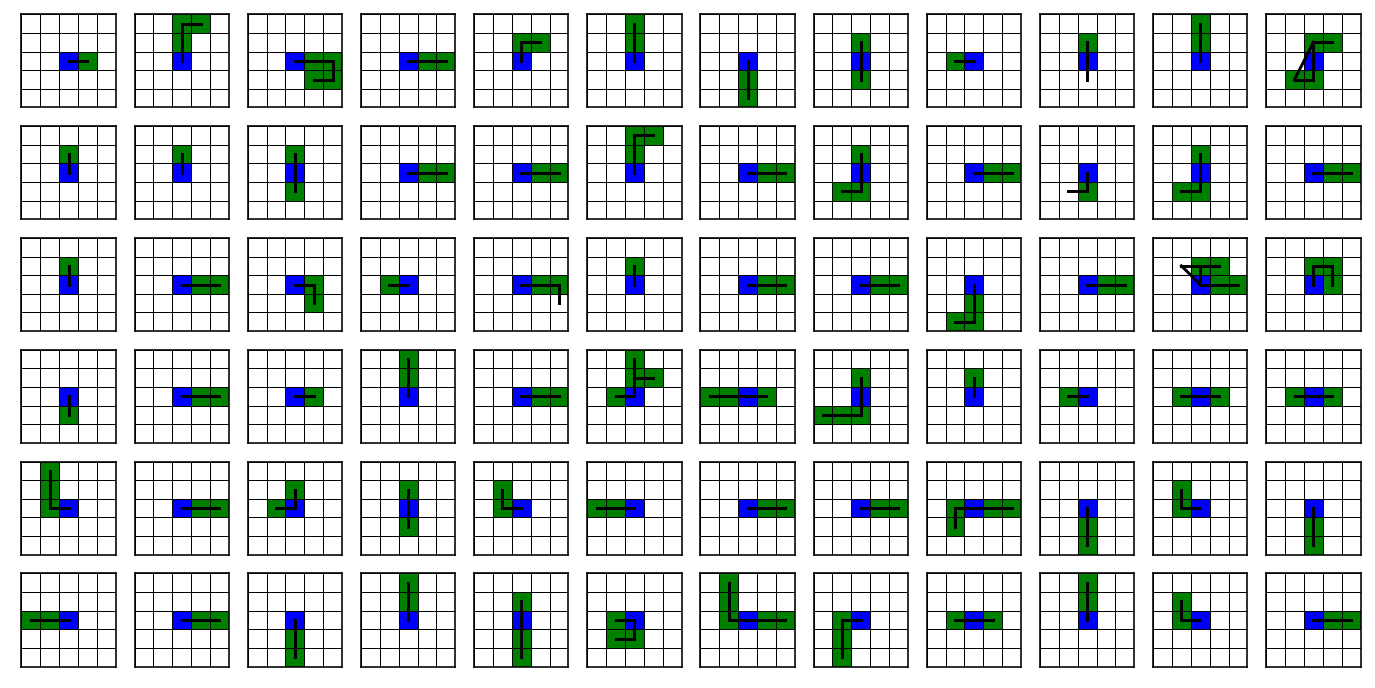

In [118]:
dream_grammar(result.grammars[1])

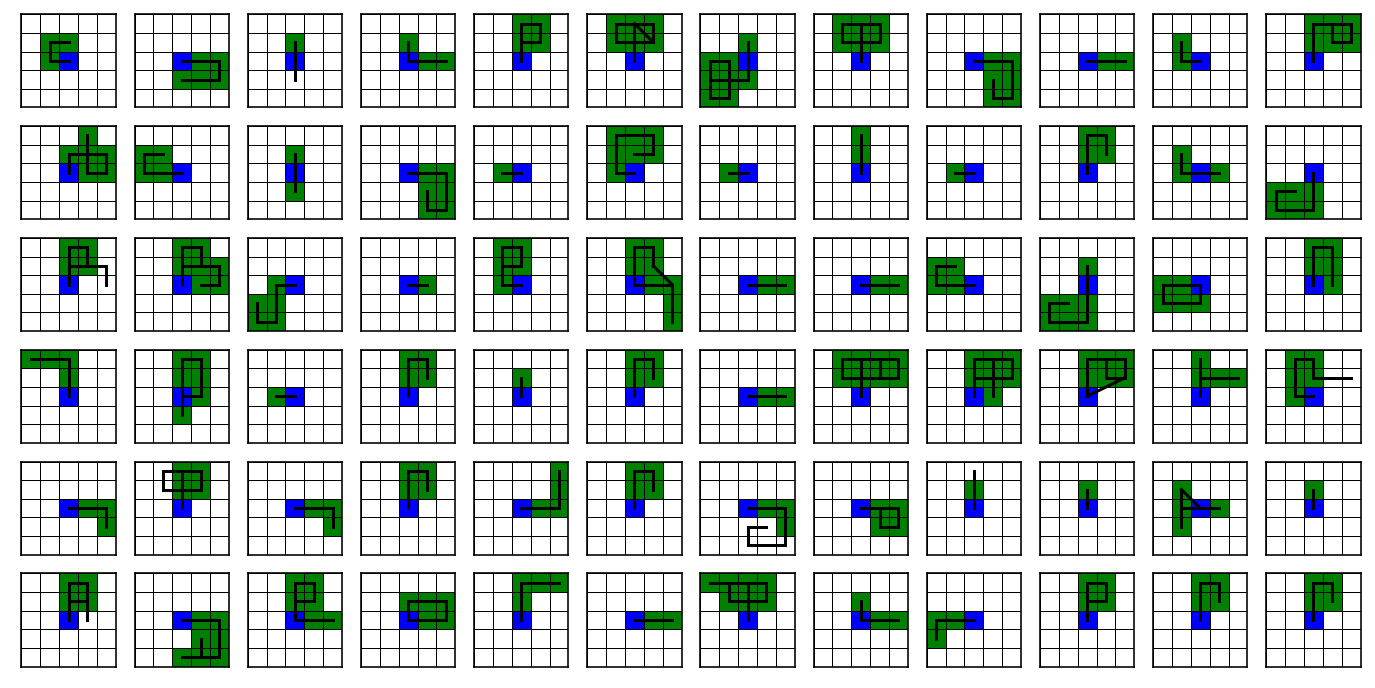

In [119]:
dream_grammar(result.grammars[2])

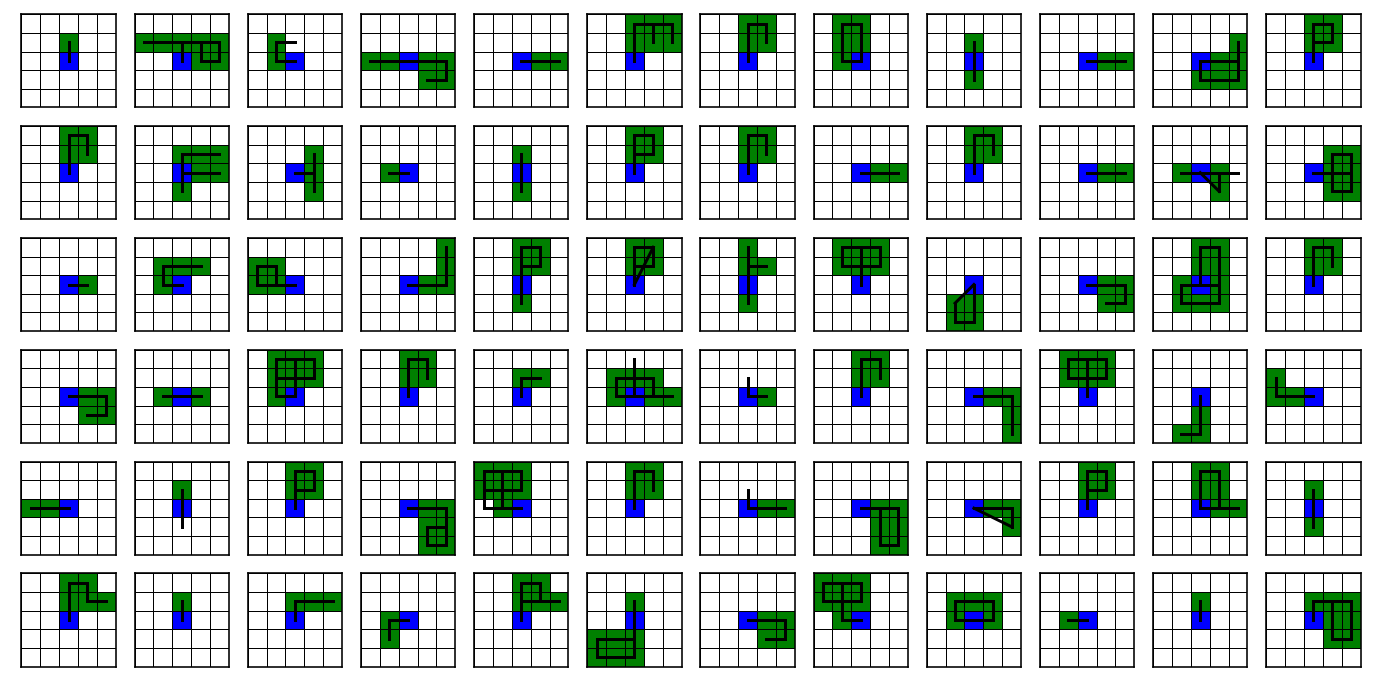

In [120]:
dream_grammar(result.grammars[3])

# library

In [121]:
def distinct(idx, grammars):
    #prev = {p for g in grammars[:idx] for p in g.primitives}
    prev = {p for p in grammars[0].primitives}
    return set(grammars[idx].primitives) - prev

distinct(2, result.grammars)

{#(lambda (#(lambda (grid_right (grid_move $0))) (grid_move (#(lambda (grid_right (grid_move $0))) (#(lambda (grid_right (grid_move $0))) $0))))),
 #(lambda (grid_right (#(lambda (grid_right (grid_move $0))) (grid_move $0)))),
 #(lambda (grid_right (grid_move $0)))}

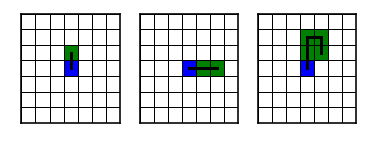

In [122]:
def visualize_functions(fns):
    if not fns:
        print('No functions')
        return

    f, axes = plt.subplots(1, len(fns), figsize=(len(fns), 1))

    for fn, ax in zip(fns, axes):
        start, location = np.array([[0]*7]*7), (3, 3)
        start[location] = 1
        s = executeGrid(fn, GridState(start, location, history=[]))
        showtask(start, s.grid, s.history, ax=ax)

visualize_functions(distinct(2, result.grammars))

library after iteration 1


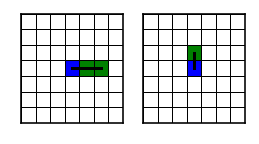

library after iteration 2


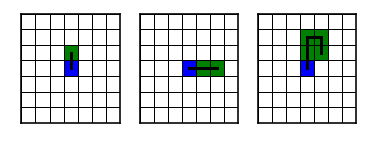

library after iteration 3


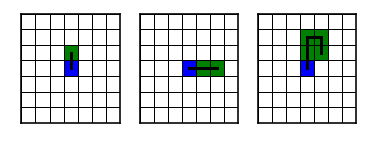

In [123]:
for i in range(1, len(result.grammars)):
    print(f'library after iteration {i}')
    visualize_functions(distinct(i, result.grammars))
    plt.show()